In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy import signal

In [ ]:
import time
import nidaqmx
from nidaqmx.constants import AcquisitionType, TerminalConfiguration

DEVICE = "cDAQ1Mod1"       # NI-9215 module name
CHANNELS = ["ai0", "ai1"]  # First -> signal1, Second -> signal2
V_RANGE = (-10.0, 10.0)

# --- Acquisition params ---
SAMPLE_RATE = int(1e5)     # 100 kS/s per channel
DURATION_SEC = 10          # Record exactly 10 seconds, then stop
SAMPLES_PER_READ = 10000   # Block size per read (per channel)

def build_channel_string(device: str, channels: list[str]) -> list[str]:
    return [f"{device}/{ch}" for ch in channels]

chan_names = build_channel_string(DEVICE, CHANNELS)
if len(chan_names) != 2:
    raise ValueError("This script expects exactly 2 channels (ai0, ai1).")

target_samples_per_ch = SAMPLE_RATE * DURATION_SEC
total_samples_per_ch = 0

# DAQ buffer ~2 seconds to reduce overflow risk at high rate
daq_buffer = max(int(SAMPLE_RATE * 2), SAMPLES_PER_READ * 2)

# Accumulate blocks here; we’ll concatenate once at the end
blocks_ch0 = []
blocks_ch1 = []

with nidaqmx.Task() as task:
    # Configure channels (NI-9215 is differential)
    for name in chan_names:
        task.ai_channels.add_ai_voltage_chan(
            physical_channel=name,
            min_val=V_RANGE[0],
            max_val=V_RANGE[1],
            terminal_config=TerminalConfiguration.DIFF,
        )

    # Timing: continuous, fixed rate
    task.timing.cfg_samp_clk_timing(
        rate=SAMPLE_RATE,
        sample_mode=AcquisitionType.CONTINUOUS,
        samps_per_chan=daq_buffer,
    )

    # (Optional) explicitly size input buffer
    try:
        task.in_stream.input_buf_size = daq_buffer
    except Exception:
        pass

    task.start()

    t0 = time.time()
    try:
        while total_samples_per_ch < target_samples_per_ch:
            to_read = min(
                SAMPLES_PER_READ,
                target_samples_per_ch - total_samples_per_ch
            )

            # Read a block from both channels; returns list[list[float]] or ndarray
            data = task.read(
                number_of_samples_per_channel=to_read,
                timeout=10.0,
            )
            arr = np.asarray(data, dtype=np.float64)

            # Ensure shape (2, N)
            if arr.ndim == 1:
                # nidaqmx can return flat when single sample; normalize
                arr = arr.reshape(2, -1)
            elif arr.shape[0] != 2 and arr.shape[1] == 2:
                # If shape is (N, 2), transpose to (2, N)
                arr = arr.T

            n = arr.shape[1]

            # Append blocks (copy to ensure contiguous 1D later)
            blocks_ch0.append(np.ascontiguousarray(arr[0, :]))
            blocks_ch1.append(np.ascontiguousarray(arr[1, :]))

            total_samples_per_ch += n

            # Console progress
            elapsed = time.time() - t0
            pct = 100.0 * total_samples_per_ch / target_samples_per_ch
            rate_est = total_samples_per_ch / elapsed if elapsed > 0 else 0.0
            print(
                f"\rRecorded {total_samples_per_ch:,}/{target_samples_per_ch:,} samples/ch "
                f"({pct:5.1f}%)  ~{rate_est:,.0f} S/s/ch",
                end="",
                flush=True,
            )

    except KeyboardInterrupt:
        print("\nStopping early (Ctrl+C detected)...")
    finally:
        try:
            task.stop()
        except Exception:
            pass

signal1 = np.concatenate(blocks_ch0, axis=0)
signal2 = np.concatenate(blocks_ch1, axis=0)

# Sanity check and quick peek
print("First 10 samples ch0 (signal1):", signal1[:10])
print("First 10 samples ch1 (signal2):", signal2[:10])
print("Signal1 length:", len(signal1))
print("Signal2 length:", len(signal2))
print("dtype:", signal1.dtype)

# Write down the data to a text file
np.savetxt("sig3.txt", signal1)
np.savetxt("sig4.txt", signal2)

KeyboardInterrupt: 

In [ ]:
# Read measurement data from file
filename = "signal1.txt" # CHANGE PATH ACCORDINGLY

def _to_float(s):
    # Works whether numpy gives bytes or str
    if isinstance(s, bytes):
        s = s.decode("utf-8", errors="ignore")
    return float(s.replace(",", "."))  # convert comma decimal to dot

# If your file has a header line, add: skiprows=1
signal1= np.loadtxt(
    filename,
    delimiter="\t",
    converters={0: _to_float},
    unpack=True,          # gives t, u directly (no .T needed)
    encoding="utf-8"      # ensures numpy hands us str (but we handle both)
)

print("First 10 samples:", signal1[:10])
print("Signal1 length:", len(signal1))
print(signal1.dtype)

# Read measurement data from file
filename = "signal2.txt" # CHANGE PATH ACCORDINGLY

def _to_float(s):
    # Works whether numpy gives bytes or str
    if isinstance(s, bytes):
        s = s.decode("utf-8", errors="ignore")
    return float(s.replace(",", "."))  # convert comma decimal to dot

# If your file has a header line, add: skiprows=1
signal2 = np.loadtxt(
    filename,
    delimiter="\t",
    converters={0: _to_float},
    unpack=True,          # gives t, u directly (no .T needed)
    encoding="utf-8"      # ensures numpy hands us str (but we handle both)
)

print("First 10 time samples:", signal2[:10])
print("Signal2 length:", len(signal2))
print(signal2.dtype)

First 10 samples: [ 0.28182129  0.22193295  0.12764067  0.02602163 -0.01921318  0.01264232
  0.1104387   0.21938451  0.27959141  0.259841  ]
Signal1 length: 1000000
float64
First 10 time samples: [0.19331353 0.44052563 0.60712508 0.56760908 0.36433878 0.14462982
 0.0529527  0.12661052 0.28941644 0.42535148]
Signal2 length: 1000000
float64


In [ ]:
# Read measurement data from file
filename = "olcum1.txt" # CHANGE PATH ACCORDINGLY

def _to_float(s):
    # Works whether numpy gives bytes or str
    if isinstance(s, bytes):
        s = s.decode("utf-8", errors="ignore")
    return float(s.replace(",", "."))  # convert comma decimal to dot

# If your file has a header line, add: skiprows=1
signal1, signal2 = np.loadtxt(
    filename,
    delimiter="\t",
    converters={0: _to_float, 1: _to_float},
    unpack=True,          # gives t, u directly (no .T needed)
    encoding="utf-8"      # ensures numpy hands us str (but we handle both)
)

print("First 10 time samples:", signal1[:10])
print("First 10 amplitude samples:", signal2[:10])
print("Signal1 length:", len(signal1))
print("Signal2 length:", len(signal2))
print(signal1.dtype)

FileNotFoundError: olcum1.txt not found.

In [4]:
# Parameters
fs = 1e5
N = len(signal1)
T = 1.0 / fs  # fs is the sampling frequency

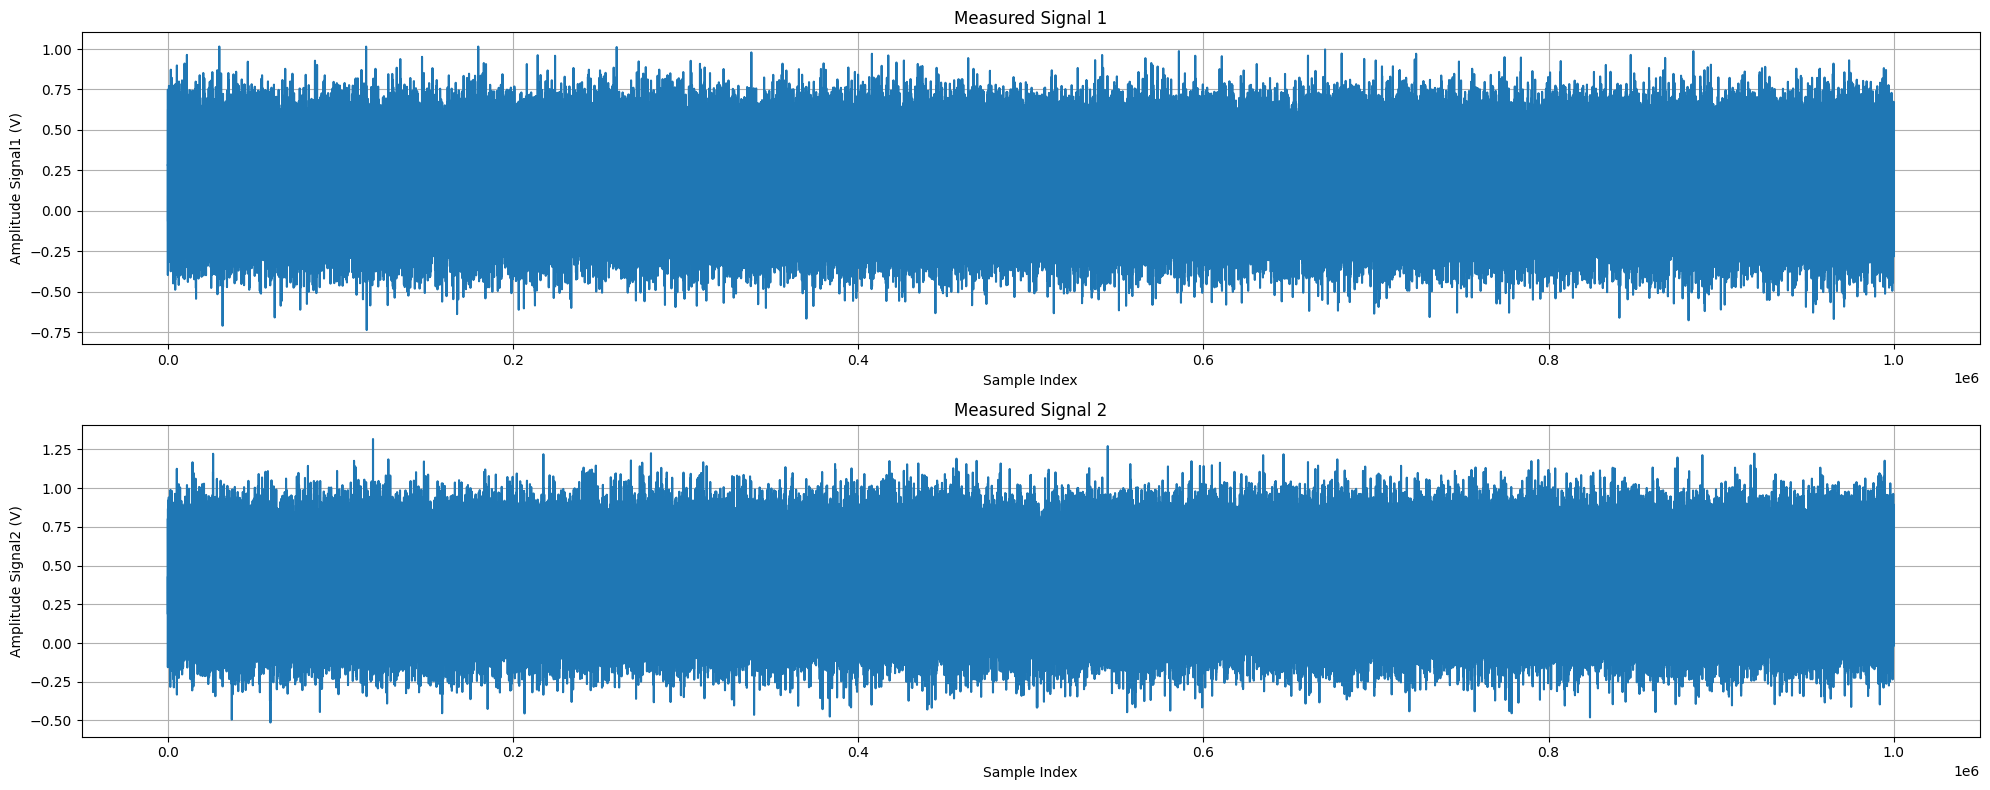

In [5]:
# Create indices of samples
indices = np.arange(len(signal1))

# Plot the measured data
plt.figure(figsize=(20,8))
plt.subplot(2, 1, 1)
plt.plot(indices, signal1)
plt.xlabel("Sample Index")
plt.ylabel("Amplitude Signal1 (V)")
plt.title("Measured Signal 1")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(indices, signal2)
plt.xlabel("Sample Index")
plt.ylabel("Amplitude Signal2 (V)")
plt.title("Measured Signal 2")
plt.grid()

plt.tight_layout()
plt.show()

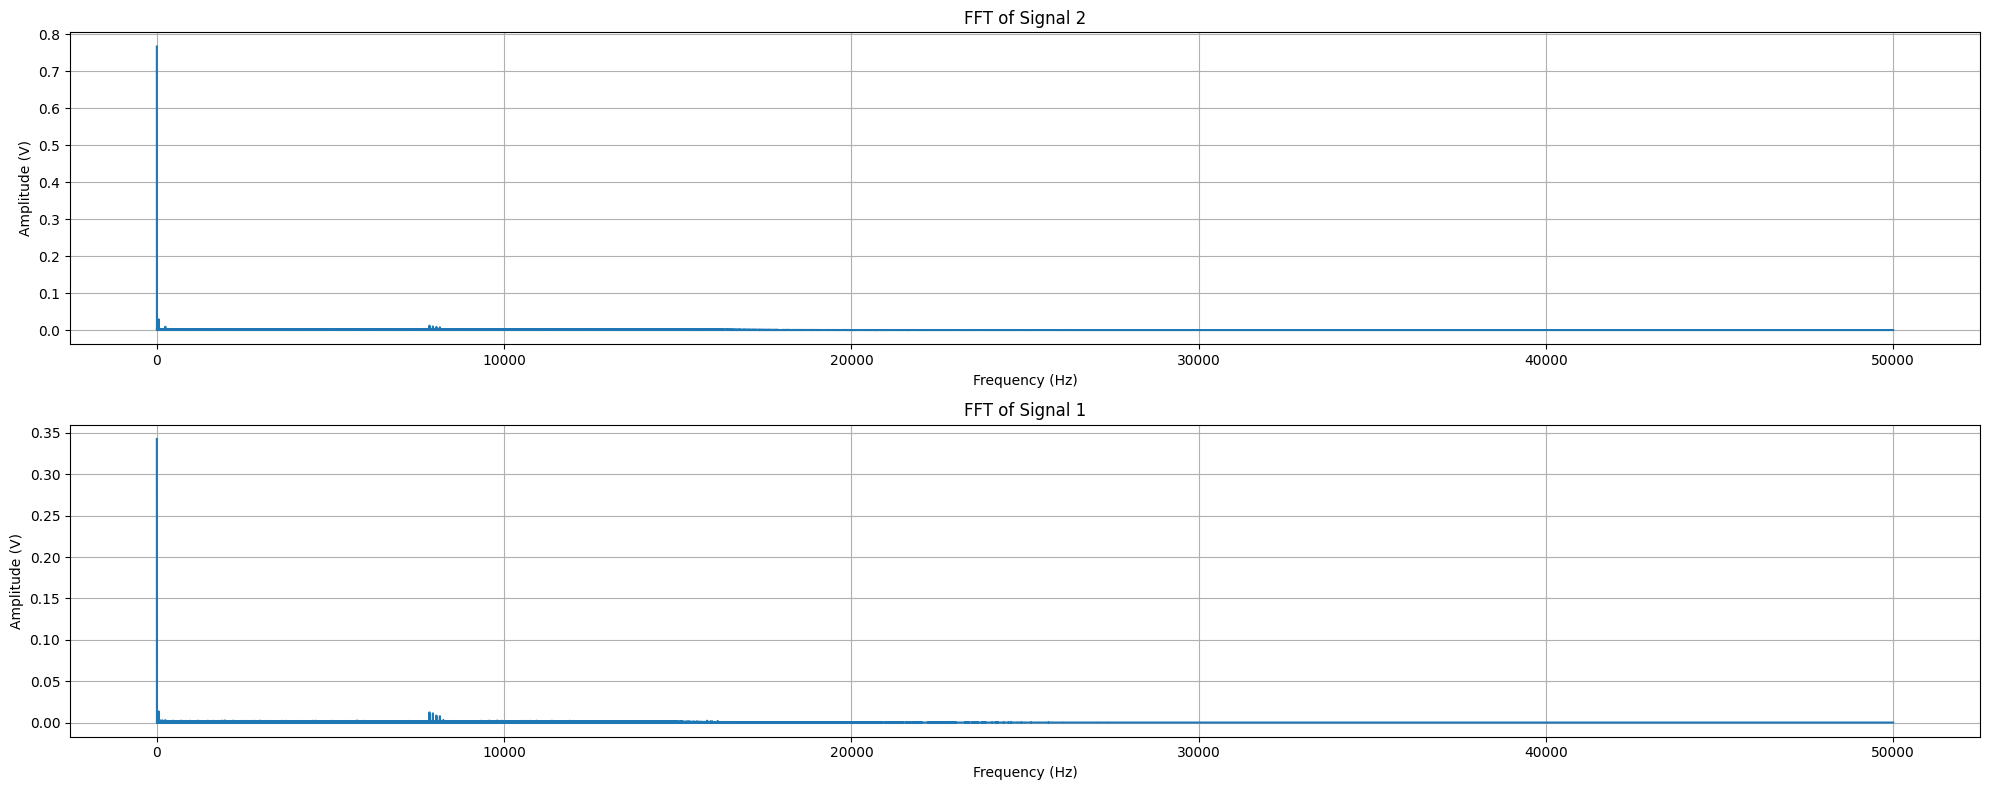

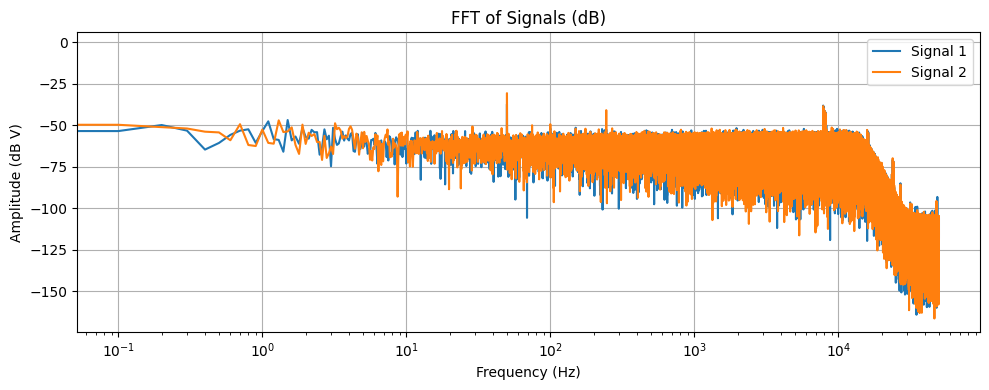

In [6]:
# Compute FFTs
yf1 = sp.fft.fft(signal1)
yf2 = sp.fft.fft(signal2)

# Compute frequencies
xf = sp.fft.fftfreq(N, T)[:N // 2]

# Same FFT plots but limited x axis
x_axis_upper_limit = 1e4
x_axis_lower_limit = -2

plt.figure(figsize=(20,8))
plt.subplot(2, 1, 2)
plt.plot(xf, 2.0 / N * np.abs(yf1[:N // 2]))
#plt.xlim(x_axis_lower_limit, x_axis_upper_limit)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (V)")
plt.title("FFT of Signal 1")
plt.grid()

plt.subplot(2, 1, 1)
plt.plot(xf, 2.0 / N * np.abs(yf2[:N // 2]))
#plt.xlim(x_axis_lower_limit, x_axis_upper_limit)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (V)")
plt.title("FFT of Signal 2")
plt.grid()

plt.tight_layout()
plt.show()

# Plot y decibel - x logarithmic
plt.figure(figsize=(10,4))
plt.semilogx(xf, 20 * np.log10(2.0 / N * np.abs(yf1[:N // 2])), label="Signal 1")
plt.semilogx(xf, 20 * np.log10(2.0 /N * np.abs(yf2[:N // 2])), label="Signal 2")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB V)")
plt.title("FFT of Signals (dB)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [7]:
# Filter between 1 Hz and 10 kHz
filter_lower_limit = 1 # Hz
filter_upper_limit = 0 # Hz

"""
b, a = signal.butter(4, [filter_lower_limit, filter_upper_limit], btype='band', fs=fs)
filtered1 = signal.filtfilt(b, a, signal1)
filtered2 = signal.filtfilt(b, a, signal2)
"""

signal1 -= np.mean(signal1)
signal2 -= np.mean(signal2)

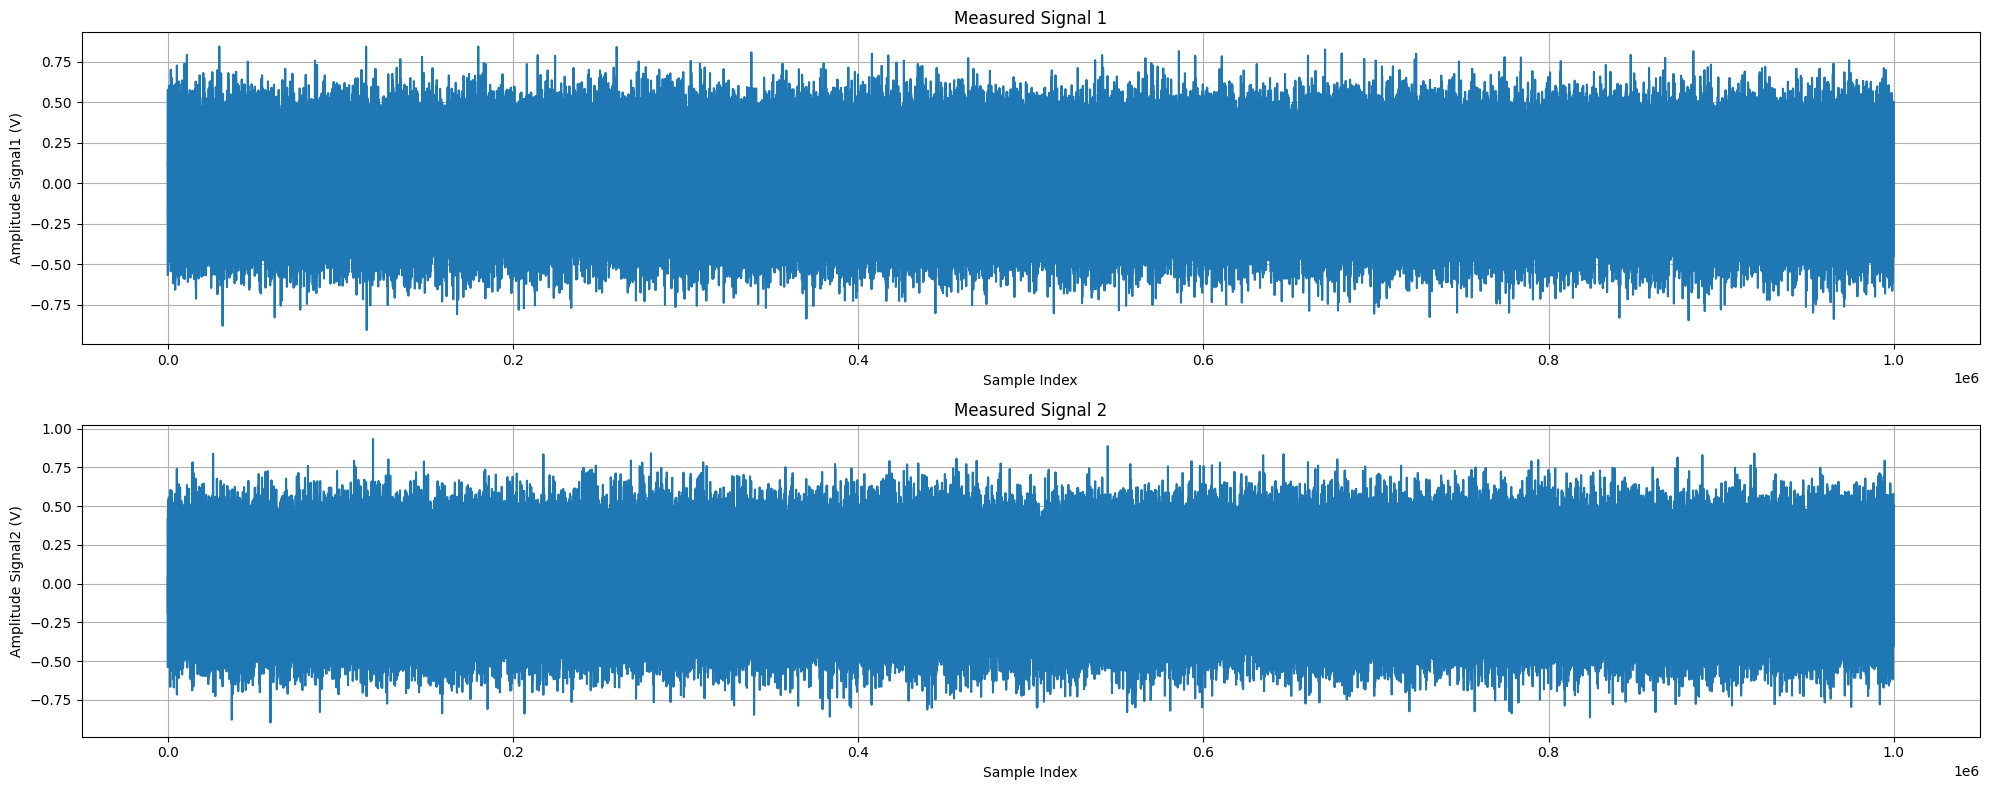

In [8]:
# Create indices of samples
indices = np.arange(len(signal1))

# Plot the measured data
plt.figure(figsize=(20,8))
plt.subplot(2, 1, 1)
plt.plot(indices, signal1)
plt.xlabel("Sample Index")
plt.ylabel("Amplitude Signal1 (V)")
plt.title("Measured Signal 1")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(indices, signal2)
plt.xlabel("Sample Index")
plt.ylabel("Amplitude Signal2 (V)")
plt.title("Measured Signal 2")
plt.grid()

plt.tight_layout()
plt.show()

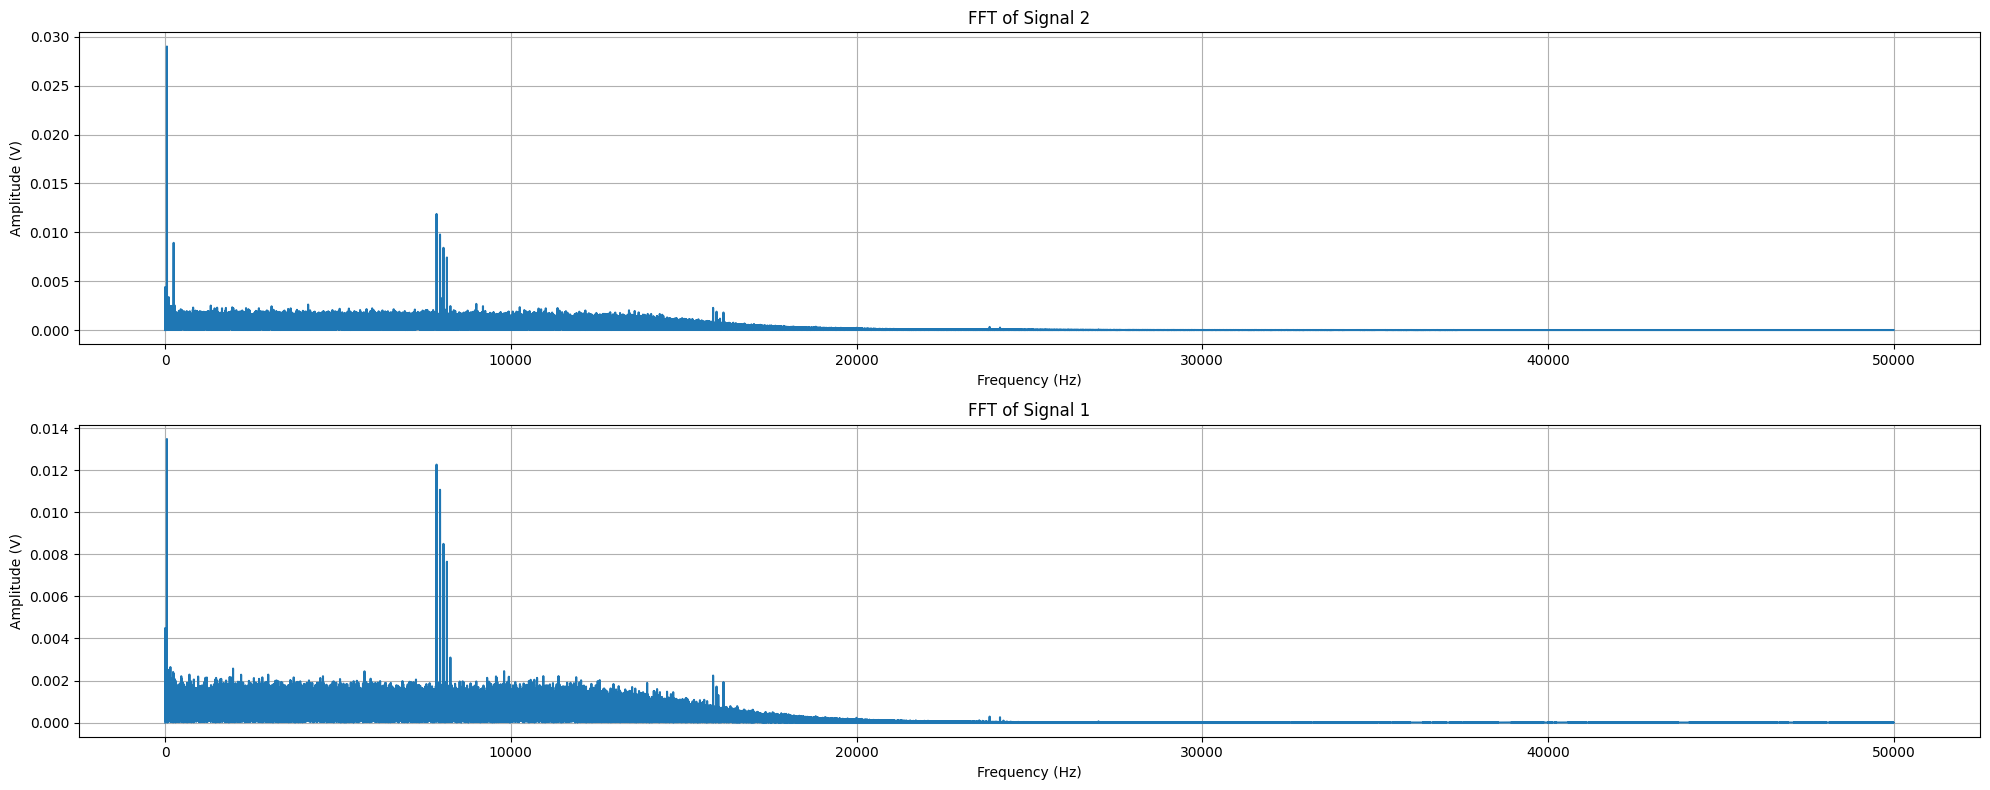

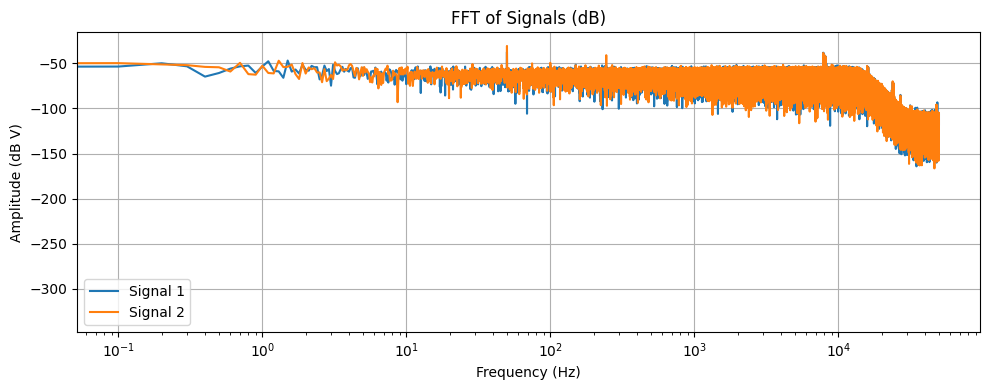

In [28]:
# Compute FFTs
yf1 = sp.fft.fft(signal1)
yf2 = sp.fft.fft(signal2)

# Compute frequencies
xf = sp.fft.fftfreq(N, T)[:N // 2]

plt.figure(figsize=(20,8))
plt.subplot(2, 1, 2)
plt.plot(xf, 2.0 / N * np.abs(yf1[:N // 2]))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (V)")
plt.title("FFT of Signal 1")
plt.grid()

plt.subplot(2, 1, 1)
plt.plot(xf, 2.0 / N * np.abs(yf2[:N // 2]))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (V)")
plt.title("FFT of Signal 2")
plt.grid()

plt.tight_layout()
plt.show()

# Plot y decibel - x logarithmic
plt.figure(figsize=(10,4))
plt.semilogx(xf, 20 * np.log10(2.0 / N * np.abs(yf1[:N // 2])), label="Signal 1")
plt.semilogx(xf, 20 * np.log10(2.0 /N * np.abs(yf2[:N // 2])), label="Signal 2")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB V)")
plt.title("FFT of Signals (dB)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

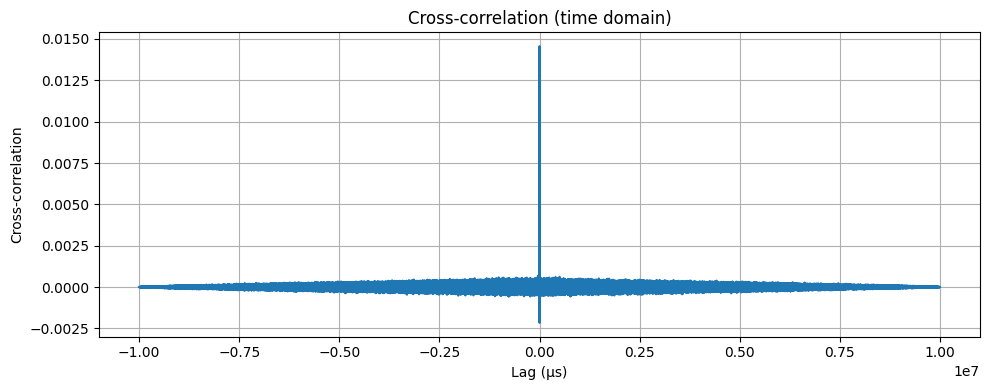

Using nperseg = 32768


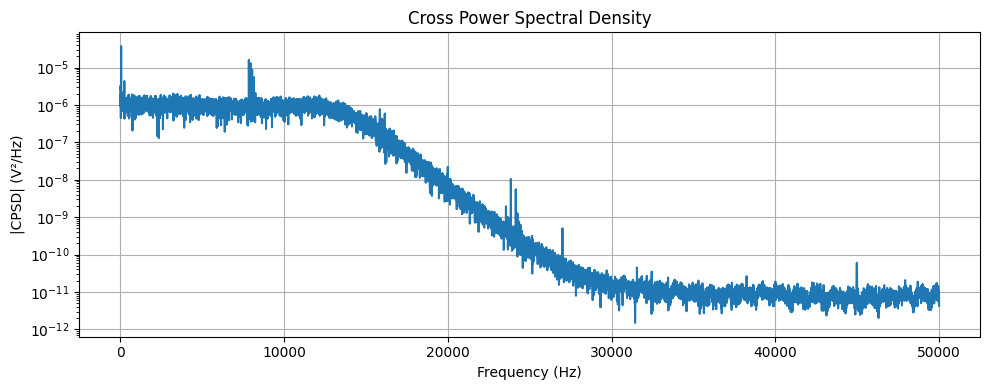

In [ ]:
# Cross-correlation (time domain)
N = len(signal1)
corr_xy = signal.correlate(signal1, signal2, mode='full', method='fft') / N
lags = np.arange(-N+1, N)
lag_sec = lags / fs

plt.figure(figsize=(10,4))
plt.plot(lag_sec*1e6, corr_xy)
plt.xlabel("Lag (µs)")
plt.ylabel("Cross-correlation")
plt.title("Cross-correlation (time domain)")
plt.grid()
plt.tight_layout()
plt.show()

# Cross Power Spectral Density (CPSD)
nperseg  = min(32768, N)
noverlap = nperseg // 2
window   = 'hann'

f, Gxy = signal.csd(
    signal1, signal2,
    fs=fs,
    window=window,
    nperseg=nperseg,
    noverlap=noverlap,
    detrend=False,
    return_onesided=True,
    scaling='density'
)

plt.figure(figsize=(10,4))
plt.semilogy(f, np.abs(Gxy))
plt.xlabel("Frequency (Hz)")
plt.ylabel("|CPSD| (V²/Hz)")
plt.title("Cross Power Spectral Density")
plt.grid()
plt.tight_layout()
plt.show()

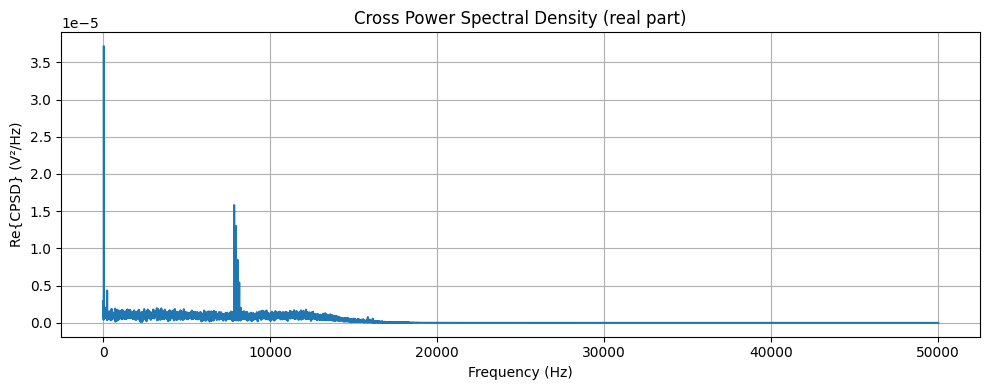

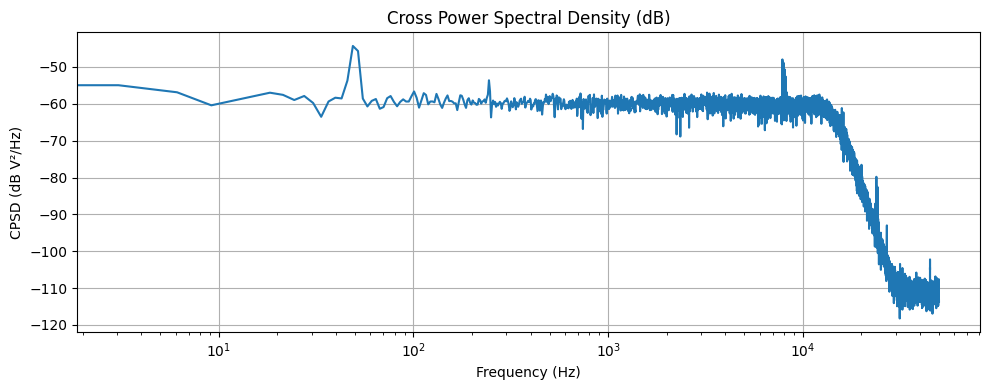

In [25]:
# Real part of CPSD
plt.figure(figsize=(10,4))
plt.plot(f, np.real(Gxy))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Re{CPSD} (V²/Hz)")
plt.title("Cross Power Spectral Density (real part)")
plt.grid()
plt.tight_layout()
plt.show()

# Plot y axis decibel - x axis logarithmic
plt.figure(figsize=(10,4))
plt.semilogx(f, 10 * np.log10(np.abs(Gxy)))
plt.xlabel("Frequency (Hz)")
plt.ylabel("CPSD (dB V²/Hz)")
plt.title("Cross Power Spectral Density (dB)")
plt.grid()
plt.tight_layout()
plt.show()

In [27]:
# Temperature from Re{CPSD}
from scipy.integrate import trapezoid

kB     = 1.380649e-23   # Boltzmann constant [J/K]
R_ohm  = 550          # <-- set your resistor value (Ohms)
G1_lin = 4e5            # <-- set channel-1 gain (Vout/Vin)
G2_lin = 4e5            # <-- set channel-2 gain (Vout/Vin)

# Choose a clean frequency band
f_lo, f_hi = 1, 15000        # <-- set band limits (Hz)
band = (f >= f_lo) & (f <= f_hi)

# Integrate real part of CPSD over the band -> mean-square voltage [V^2]
Sv_meas = trapezoid(np.real(Gxy[band]), f[band])
print(f"Sv_meas = {Sv_meas:.6e} V^2 over [{f_lo/1e3:.0f},{f_hi/1e3:.0f}] kHz")

# Compute temperature
T_K = Sv_meas / (G1_lin * G2_lin * 4*kB*R_ohm * (f_hi - f_lo))
print(f"T = {T_K:.2f} K")

Sv_meas = 1.410402e-02 V^2 over [0,15] kHz
T = 193.49 K
